In [30]:
import numpy as np 
import matplotlib.pyplot as plt 

from scipy import stats
# from scipy.interpolate import interp1d

Définition des paramètres pour l'étude:

In [31]:
# global variables
K = 100  # strike
S_0 = 100  # asset at time t=0
T = 1.0  # maturity
sigma = 0.3  # volatility
r = 0.03

# about PDE
M = 500  # nb of time points
N = 1000  # nb of space points
L = np.log(50*K)  # space limits for PDE exp(L) >> K
print(f"L: {L}")


L: 8.517193191416238


Pour vérifier les réponses que nous obtenons, nous définissons la fonction suivante qui donne le prix d'une option européenne selon le modèle de Black-Scholes suivant la solution analytique.

In [32]:
def BlackScholesPrice(S_0, K, T, sigma, r, t=0):
    d1 = (np.log(S_0/K) + (r + (sigma**2) / 2) * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    price = S_0 * stats.norm.cdf(d1) - K*np.exp(-r*(T-t)) * stats.norm.cdf(d2)
    return price

### Question 1 - Tracer le prix EDP du call européen dans le modèle de Black&Scholes en fonciton de $S_0$

In [33]:
def construct_A_matrix(sigma, h, r):
    """ 
    Function to return elements on the tridiagonal of A matrix.
    """

    a = (sigma**2)/(2*h**2) + (r - sigma**2 / 2)/(2*h)
    b = - r - (sigma/h)**2
    c = a - (r - sigma**2 / 2)/h

    return a, b, c



def EDP(K, T, sigma, r, M, N, L):
    """
    Function to solve PDE.
    Note that this function return a python function. In fact, 
    in case one wants to compute the price for a special S_0 not
    in the grid defined below, an 1-st order interpolation is made 
    to compute the price.
    """

    ### initalization 

    # definition of steps
    h = 2 * L / N  # space step 
    delta_t = T / M  # time step

    # definition of S0 and 
    S0_vector = np.array([np.exp(L - i*h) for i in range(N+1)])
    t_vector = np.array([i*delta_t for i in range(M+1)])

    # definition of A matrix
    a, b, c = construct_A_matrix(sigma, h, r)

    # initialisation of U matrix 
    U = np.zeros(shape=(N+1, M+1))

    # set conditions on limits
    U[0, 1:M+1] = np.exp(L) - K*np.exp(-r * t_vector[1:M+1])
    U[N, 1:M+1] = np.zeros_like(U[N, 1:M+1])
    U[:, 0] = np.maximum(S0_vector - K, np.zeros_like(U[:, 0]))

    ### Method = euler implicite  ###

    # definition of transition matrix
    A = a*np.eye(N=N-1, k=-1) + b*np.eye(N=N-1) + c*np.eye(N=N-1, k=1) 
    transition_matrix = np.linalg.inv(np.eye(N-1) - delta_t * A)

    # compute all columns of U
    for i in range(1, M+1):

        # add influence of limits
        U[1, i-1] += a * delta_t * U[0, i-1]  
        U[N-1, i-1] += c * delta_t * U[N, i-1]

        # compute i-th column
        U[1:N, i] = np.matmul(transition_matrix, U[1:N, i-1])

    # return interp1d(S0_vector, U[:, -1], kind='linear', fill_value='extrapolate')
    return lambda x: np.interp(x, S0_vector[::-1], U[:, -1][::-1])
    



En utilisant la fonction EDP, on résout l'EDP sur l'espace définit par les paramètres passés en argument pour obtenir une fonction qui prend comme argument $S_0$ et qui retourne le prix du call.

In [34]:
# compute european call price using PDE
PDE_function = EDP(K, T, sigma, r, M, N, L)

Pour vérifier si notre solution retourne une valeur proche de la vraie valeur, on plot la solution EDP et la solution théroque sur tout l'intervalle ainsi que l'erreur associée. 

C:\Users\elkan\AppData\Local\Temp\ipykernel_9544\963868362.py:2: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S_0/K) + (r + (sigma**2) / 2) * (T-t)) / (sigma * np.sqrt(T-t))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


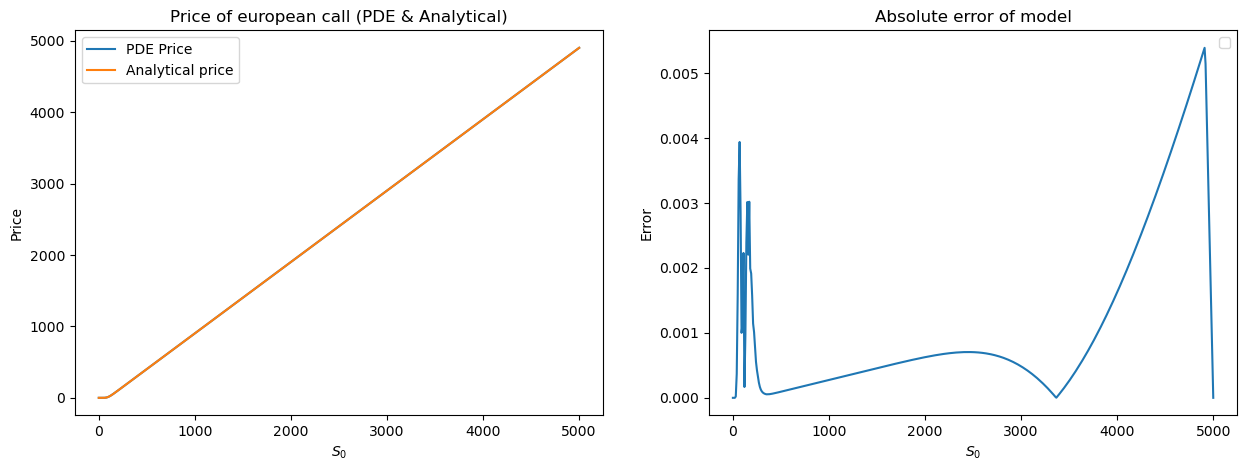

In [35]:
# define values on axis
x = np.linspace(0, np.exp(L), 500)

# compute PDE-method predictions and actual values
y = PDE_function(x)
y_analytic = BlackScholesPrice(x, K, T, sigma, r)

# plot of european call 
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# figure1
ax[0].plot(x, y, label="PDE Price")
ax[0].plot(x, y_analytic, label="Analytical price")
ax[0].set_title("Price of european call (PDE & Analytical)")
ax[0].set_xlabel("$S_0$")
ax[0].set_ylabel("Price")
ax[0].legend()

# figure 2 
# ax[1].plot(x, y, label="PDE price")
ax[1].plot(x, np.abs(y - y_analytic))
ax[1].set_title("Absolute error of model")
ax[1].set_xlabel("$S_0$")
ax[1].set_ylabel("Error")
ax[1].legend()

plt.show()

Sur la figure ci-dessus, on peut voir que le prix prédit par la méthode EDP coincide très bien avec la solution analytique. On peut observer une erreur maximale d'environ $0.01$. Notons tout de même deux choses: 
1) Les erreurs sont assez importantes autour du strike: ceci est assez logique puisque nous nous situons autour des points de non-linéarité. 
2) L'erreur devient importante pour de grand $S_0$: ceci s'explique par la discrétisation en "échelle log" de notre EDP en terme spatiale. L'écart entre deux valeurs consécutives varie exponentiellement et par conséquent, l'erreur aussi. Toutefois, le bord étant fixé par les contraintes du problème, l'erreur est nulle sur les bords. 

Toutefois, nous proposons de voir l'évolution de l'erreur sur des valeurs qui nous intéressent: $S_0 \in [0, 3\times K]$ afin notamment de confirmer le point 1 ci-dessus: 

C:\Users\elkan\AppData\Local\Temp\ipykernel_9544\963868362.py:2: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S_0/K) + (r + (sigma**2) / 2) * (T-t)) / (sigma * np.sqrt(T-t))


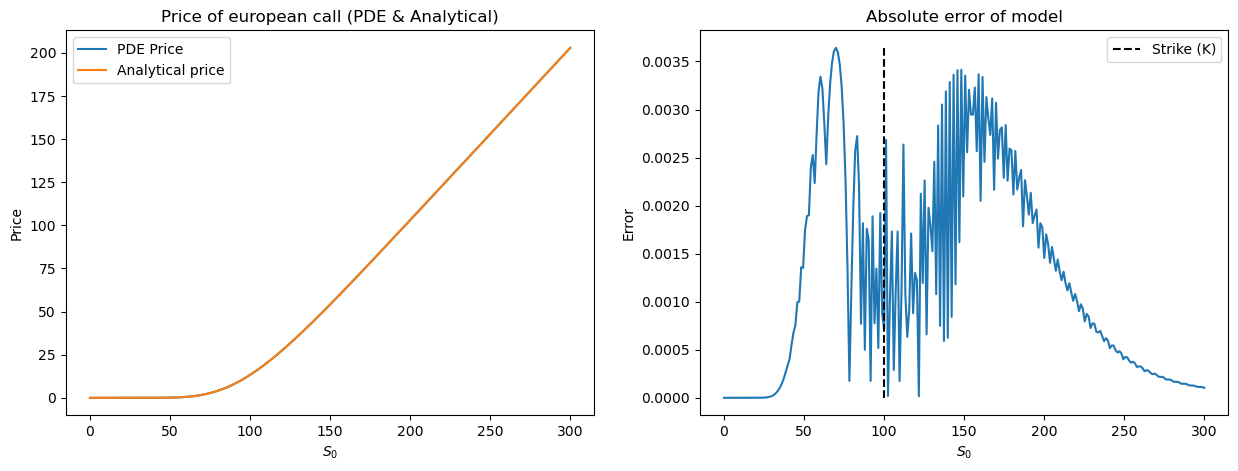

In [36]:
# define values on axis
x = np.linspace(0, 3*K, 250)

# compute PDE-method predictions and actual values
y = PDE_function(x)
y_analytic = BlackScholesPrice(x, K, T, sigma, r)

# plot of european call 
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# figure1
ax[0].plot(x, y, label="PDE Price")
ax[0].plot(x, y_analytic, label="Analytical price")
ax[0].set_title("Price of european call (PDE & Analytical)")
ax[0].set_xlabel("$S_0$")
ax[0].set_ylabel("Price")
ax[0].legend()

# figure 2 
# ax[1].plot(x, y, label="PDE price")
ax[1].plot(x, np.abs(y - y_analytic))
ax[1].vlines(K, ymin=0., ymax=np.amax(np.abs(y - y_analytic)), 
             linestyle='--', color="black", label="Strike (K)")
ax[1].set_title("Absolute error of model")
ax[1].set_xlabel("$S_0$")
ax[1].set_ylabel("Error")
ax[1].legend()

plt.show()

Premièrement, on peut voir que l'erreur est au maximum de l'odre de $10^{-3}$. Ainsi, l'erreur etant aussi faible, nous ne pouvons pas la discenrer sur le plot de gauche. 

Deuxièmement, on peut effectivement voir que l'erreur se concentre autour du strike. De plus, nous pouvons voir beaucoup d'oscillations qui sont dues à l'interpolation. L'interpolation au premier ordre n'est sans doute pas la meilleur option mais reste néanmoins d'effet négligeable. 

### Question 2 - Tracer l'erreur en norme inifinie du vecteur prix EDP en fonction de N.

On s'attend dans cette question à un ordre de convergence égale à 2 i.e. 
$$ Error \sim \frac{1}{N^2} $$ 
donc à, 
$$ log(Error) \sim -2 \times log(N) $$ 

Nous commençons par définir les valeurs de N que nous voulons tester dans cette question:

In [37]:
N_values = np.arange(100, 2000, 20)

Effectuons maintenant l'expérience. Pour cela, nous nous intéressons d'abord à la convergence de notre estimateur sur le segment 
$$ S_0 \in [0; 3 \times K] $$

Pour cela, nous discrétisons ce segment avec un pas régulier. Puis, grâce notamment à l'interpolation dans notre fonction EDP, on calculera l'erreur sur chacun de ces points du segment.

In [38]:
# define error array
N_errors = np.zeros_like(N_values, dtype=np.float64)

# define targets (anlaytical solution)
x = np.linspace(0, 3*K, 200)
targets = BlackScholesPrice(x, K, T, sigma, r)

# compute error for each value of N 
for i, n in enumerate(N_values):

    # compute PDE output
    PDE_function = EDP(K, T, sigma, r, M, n, L)
    y = PDE_function(x)

    # compute errors
    error = np.amax(np.abs(targets - y))
    N_errors[i] = error

C:\Users\elkan\AppData\Local\Temp\ipykernel_9544\963868362.py:2: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S_0/K) + (r + (sigma**2) / 2) * (T-t)) / (sigma * np.sqrt(T-t))


Slope: -2.0816994915315856


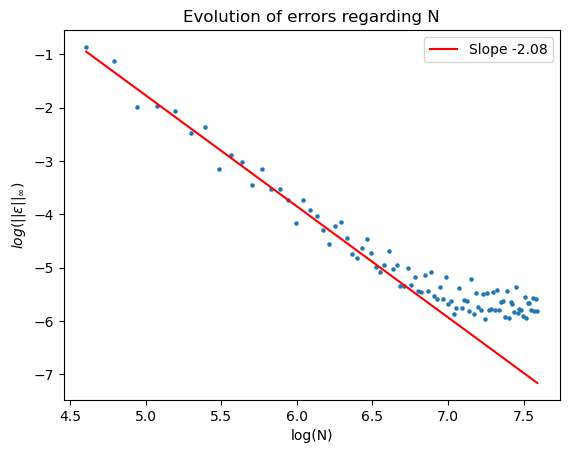

In [39]:
# define x-aaxis and y-axis
log_N_values = np.log(N_values)
log_N_errors = np.log(N_errors)

# linear regression
lin_reg = stats.linregress(log_N_values[:20], log_N_errors[:20])
slope, intercept = lin_reg.slope, lin_reg.intercept
print(f"Slope: {slope}")

# plot error
plt.scatter(log_N_values, log_N_errors, s=5.)
plt.plot(log_N_values, slope*log_N_values+intercept, 
         label=f"Slope {round(slope, 2)}", color="red")
plt.title("Evolution of errors regarding N")
plt.xlabel("log(N)")
plt.ylabel("$log(||\epsilon||_\infty)$")
plt.legend()

plt.show()

On peut observer sur la figure ci-dessus un ordre de convergence proche de 2 au début. Pour des valeurs de N raisonnables, nous sommes proches de la valeur de 2 attendue. Cependant, quand N grandit, on peut observer que l'ordre de convergence faiblit. Ceci s'explique par le déséquilibre entre le maillage en temps et en espace. La pas en espace devient beaucoup plus fin que le pas en temps. 

Dans un second moment, nous nous intéressons à la convergence du vecteur prix (extrait de la maille utilisée par la fonction EDP correspondant au prix à t=0). 

Pour cela, nous récupérons la denrière colonne puis mesurons l'erreur en chacun des points. Notons que plus N grandit, plus le vecteur de prix à t=0 grandit également. On s'attend donc à observer un plateau lorsque le pas d'espace devient trop fin par rapport au pas de temps. 

In [40]:
# define error array
N_errors_grid = np.zeros_like(N_values, dtype=np.float64)

# compute error for each value of N 
for i, n in enumerate(N_values):

    n = int(np.floor(n))

    # define targets (anlaytical solution)
    x = np.exp(np.linspace(-L, L, n+1))
    targets = BlackScholesPrice(x, K, T, sigma, r)

    # compute PDE output
    results = EDP(K, T, sigma, r, M, n, L)
    y = results(x)

    # compute errors
    error = np.amax(np.abs(targets - y))
    N_errors_grid[i] = error 

Slope: -2.2189931605332824


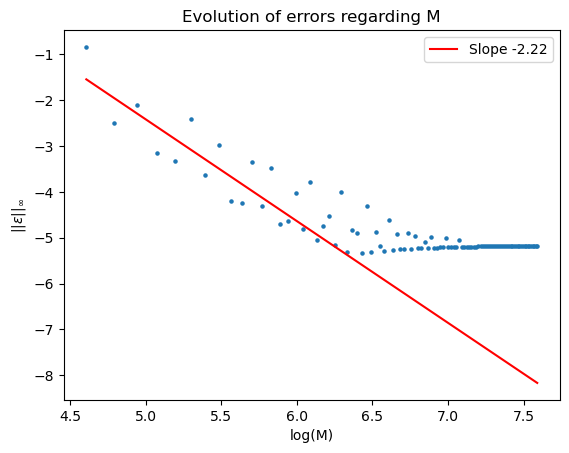

In [41]:
log_N_errors_grid = np.log(N_errors_grid)

# linear regression
lin_reg = stats.linregress(log_N_values[:15], log_N_errors_grid[:15])
slope, intercept = lin_reg.slope, lin_reg.intercept
print(f"Slope: {slope}")

# plot error
# plt.scatter(log_M_values, log_errors, s=5.)
plt.scatter(log_N_values, log_N_errors_grid, s=5.)
plt.plot(log_N_values, slope*log_N_values+intercept, 
         label=f"Slope {round(slope, 2)}", color="red")
plt.title("Evolution of errors regarding N")
plt.xlabel("log(M)")
plt.ylabel("$||\epsilon||_\infty$")
plt.legend()

plt.show()

Comme on pouvait s'y attendre, avoir un pas très fin en espace ne nous apporte plus rien si le pas temporel reste constant. On pourrait ainsi dire que "si on effectue des saut dans le temps trop grand, on perd nécessairement de l'informatio qu'on ne pourra récupérer avec un maillage de l'espace plus fin". 

### Question 3 - Tracer l'erreur en norme inifinie du vecteur prix EDP en fonction de M.

On s'attend dans cette question à un ordre de convergence égale à 1 i.e. 
$$ Error \sim \frac{1}{M} $$ 
donc à, 
$$ log(Error) \sim -1 \times log(M) $$ 

Nous commençons par définir les valeurs de M que nous voulons tester dans cette question:

In [53]:
M_values = np.arange(50, 1350, 25)

In [54]:
# define error array
M_errors = np.zeros_like(M_values, dtype=np.float64)

# define targets (anlaytical solution)
x = np.linspace(1, 3*K, 200)
targets = BlackScholesPrice(x, K, T, sigma, r)

# compute error for each value of N 
for i, m in enumerate(M_values):

    # compute PDE output
    PDE_function = EDP(K, T, sigma, r, m, N, L)
    y = PDE_function(x)

    # compute errors
    error = np.amax(np.abs(targets - y))
    M_errors[i] = error

Slope: -0.9995356879710705


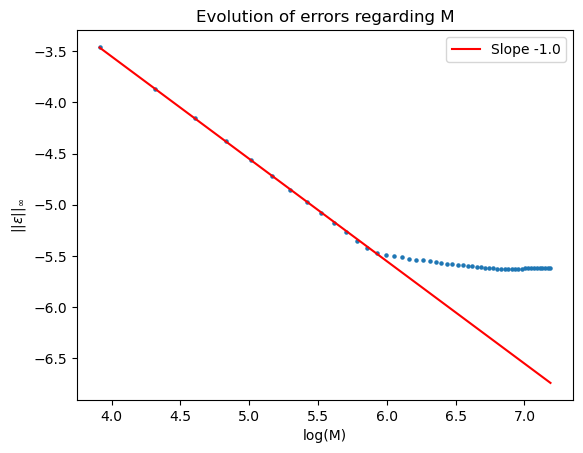

In [55]:
# define x-aaxis and y-axis
log_M_values = np.log(M_values)
log_M_errors = np.log(M_errors)

# linear regression
lin_reg = stats.linregress(log_M_values[:15], log_M_errors[:15])
slope, intercept = lin_reg.slope, lin_reg.intercept
print(f"Slope: {slope}")

# plot error
# plt.scatter(log_M_values, log_errors, s=5.)
plt.scatter(log_M_values, log_M_errors, s=5.)
plt.plot(log_M_values, slope*log_M_values+intercept, 
         label=f"Slope {round(slope, 2)}", color="red")
plt.title("Evolution of errors regarding M")
plt.xlabel("log(M)")
plt.ylabel("$||\epsilon||_\infty$")
plt.legend()

plt.show()

De la même manière qu'avec N, on observe que pour de petites valeurs de M, on approche de l'ordre de convergence souhaité id.est. 1. 

Cependant, pour de grandes valeurs de M, on observe un rythme de convergence qui s'affaiblit. Cela peut s'expliquer de la manière suivante: en raffinant le pas en temps, on ne peut pas combler le pas en espace qui reste trop grand sur le segment considérer. Ainsi, l'erreur va connaître un plateau

Dans un second moment, on considère la convergence du vecteur prix (extrait de la maille utilisée par la fonction EDP correspondant au prix à t=0). 

Cette fois, quand N grandit, la taille de ce vecteur ne change pas: on change le pas en temps mais pas en espace. Ainsi, on s'attend à ce que plus le pas en temps devient fin, plus l'erreur diminue sans connaître de plateau. En effet, plus on raffine le pas en temps moins on perd d'information à un nombre de point de l'espace fixé. 

In [56]:
# define error array
M_errors_grid = np.zeros_like(M_values, dtype=np.float64)

# compute target (independant of M)
# define targets (anlaytical solution)
x = np.exp(np.linspace(-L, L, N+1))
targets = BlackScholesPrice(x, K, T, sigma, r)

# compute error for each value of N 
for i, m in enumerate(M_values):

    m = int(np.floor(m))

    # compute PDE output
    results = EDP(K, T, sigma, r, m, N, L)
    y = results(x)

    # compute errors
    error = np.amax(np.abs(targets - y))
    M_errors_grid[i] = error 

Slope: -1.0084162885517172


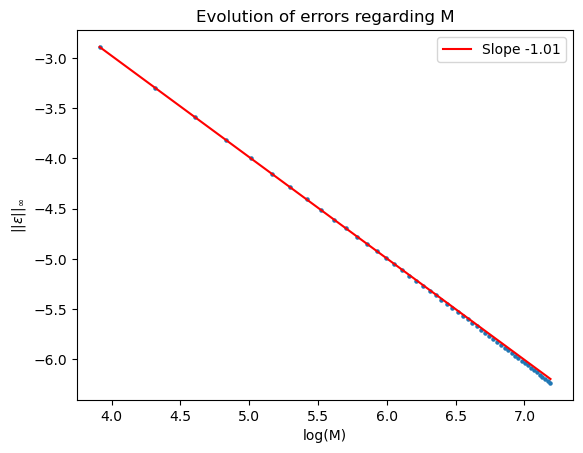

In [57]:
log_M_errors_grid = np.log(M_errors_grid)

# linear regression
lin_reg = stats.linregress(log_M_values[:15], log_M_errors_grid[:15])
slope, intercept = lin_reg.slope, lin_reg.intercept
print(f"Slope: {slope}")

# plot error
# plt.scatter(log_M_values, log_errors, s=5.)
plt.scatter(log_M_values, log_M_errors_grid, s=5.)
plt.plot(log_M_values, slope*log_M_values+intercept, 
         label=f"Slope {round(slope, 2)}", color="red")
plt.title("Evolution of errors regarding M")
plt.xlabel("log(M)")
plt.ylabel("$||\epsilon||_\infty$")
plt.legend()

plt.show()

Comme prévu, dans ce cas, on observe pas d'affaiblissement de la convergence. Ceci était prévisible puisque M change sans variation de N. 

### Question 4 - Tracer l'erreur ponctuelle en tout point de la maille pour 
$t = T - j\Delta T, j\in [0, T]$ , $S=e^{y_i}\in [e^{-L}, e^L]$

Pour commencer, nous reprenons notre fonction EDP que nous modifions légèrement pour cette question afin d'output la maille plutôt qu'une fonciton. Nous renommons cette fonction EDP_Q4: 

In [47]:
def EDP_Q4(K, T, sigma, r, M, N, L):
    """
    Function to solve PDE.
    """

    ### initalization 

    # definition of steps
    h = 2 * L / N  # space step 
    delta_t = T / M  # time step

    # definition of S0 and 
    S0_vector = np.array([np.exp(L - i*h) for i in range(N+1)])
    t_vector = np.array([i*delta_t for i in range(M+1)])

    # definition of A matrix
    a, b, c = construct_A_matrix(sigma, h, r)

    # initialisation of U matrix 
    U = np.zeros(shape=(N+1, M+1))

    # set conditions on limits
    U[0, 1:M+1] = np.exp(L) - K*np.exp(-r * t_vector[1:M+1])
    U[N, 1:M+1] = np.zeros_like(U[N, 1:M+1])
    U[:, 0] = np.maximum(S0_vector - K, np.zeros_like(U[:, 0]))

    ### Method = euler implicite  ###

    # definition of transition matrix
    A = a*np.eye(N=N-1, k=-1) + b*np.eye(N=N-1) + c*np.eye(N=N-1, k=1) 
    transition_matrix = np.linalg.inv(np.eye(N-1) - delta_t * A)

    # initialization of output matrix
    output = np.copy(U)

    # compute all columns of U
    for i in range(1, M+1):

        # add influence of limits 
        U[1, i-1] += a * delta_t * U[0, i-1]  
        U[N-1, i-1] += c * delta_t * U[N, i-1]

        # compute i-th column
        U[1:N, i] = np.matmul(transition_matrix, U[1:N, i-1])

        output[1:N, i] = U[1:N, i]

    # return the whole matrix instead of a function
    return output


Maintenant, nous allons calculer la valeur théorique en chacun de points. 

In [48]:
# define time steps
h = 2 * L / N  # space step 
delta_t = T / M  # time step

# define SO and t sequences
S0_vector = np.array([np.exp(L - i*h) for i in range(N+1)])
t_vector = np.array([i*delta_t for i in range(M+1)])

# initialisation of solution 
theoric_values = np.zeros(shape=(N+1, M+1))
theoric_values[:, 0] = np.maximum(S0_vector - K, np.zeros_like(S0_vector))

for index, _ in np.ndenumerate(theoric_values):
    i, j = index

    if j == 0:
        continue

    s0 = S0_vector[i]
    t = t_vector[j]
    theoric_values[i, j] = BlackScholesPrice(s0, K, T, sigma, r, T-t)

Puis nous retournons la grille de notre fonction EDP. 

In [49]:
solved_PDE = EDP_Q4(K, T, sigma, r, M, N, L)

Enfin, nous pouvons observer l'erreur de la méthode EDP sur un graphe 3d.

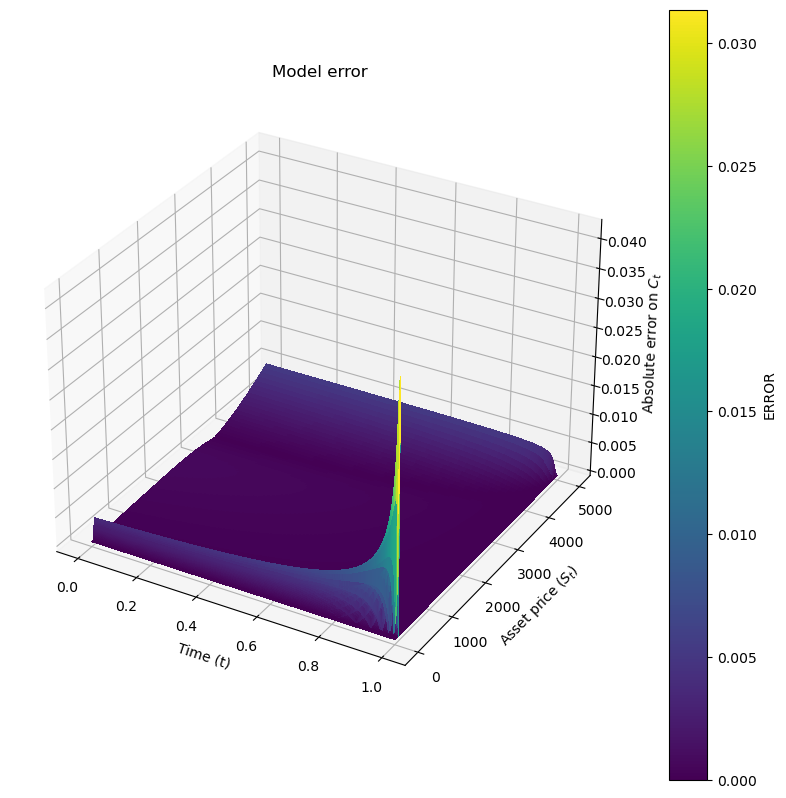

In [50]:
# prepare data
x = t_vector  # define time vector
y = S0_vector  # define space vector
x, y = np.meshgrid(x, y)   # Create a grid of coordinates

# Generate corresponding z 
z = np.abs((solved_PDE - theoric_values))
z = np.fliplr(z)  # to reverse back time

# Create a 3D surface plot with color mapping
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x, y, z, cmap='viridis', rstride=1, cstride=1, linewidth=0, antialiased=False)

# Add colorbar
cbar = plt.colorbar(surface)
cbar.set_label('ERROR')

# Set axis labels
ax.set_xlabel('Time (t)')
ax.set_ylabel('Asset price $(S_t)$')
ax.set_zlabel('Absolute error on $C_t$')

# Set plot title
plt.title('Model error')

# Show the plot
plt.show()

Dans cette question nous confirmons les hypothèses de la question 1. Le modèle fait davantage d'erreur au voisinage du strike. 
De plus, cette erreur est d'autant plus importante que t est proche de T car la non-linéarité est d'autant plus forte, on se rapproche de: 

$$ max(S_T - K, 0) $$ 

qui est un fonction très "non-linéaire" et donc difficile à approximer par la méthode EDP.